In [12]:
import torchaudio
torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
import torch
from torch.utils.data import DataLoader, Dataset
from torchaudio import transforms, models
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchviz import make_dot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import librosa
from pydub import AudioSegment
import random
from tqdm import tqdm
np.random.seed(seed:=69)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

In [13]:
root_dir = './input/'
audio_path = './input/speaking/'
noise_path = './input/crowd_noise/'

In [14]:
# all audio files are in type .mp3
audio_li = [os.path.join(audio_path, p) for p in os.listdir(audio_path)]
noise_li = [os.path.join(noise_path, p) for p in os.listdir(noise_path)]
audio_li[0]

'./input/speaking/12 Comics You Need to See - Comedy Central Stand-Up Presents.mp3.wav'

In [15]:
if False: # already ran it, but this is a way to change mp3 to wav
    if not os.path.exists('./input/wav_clean'):
        os.mkdir('./input/wav_clean')
        os.mkdir('./input/wav_crowd_noise')

    for i in audio_li:
        waveform = AudioSegment.from_mp3(i)
        waveform.export(f"./input/wav_clean/{i.split('/')[-1]}.wav", format="wav")
    for i in noise_li:
        waveform = AudioSegment.from_mp3(i)
        waveform.export(f"./input/wav_crowd_noise/{i.split('/')[-1]}.wav", format="wav")

In [16]:
torchaudio.get_audio_backend()

'soundfile'

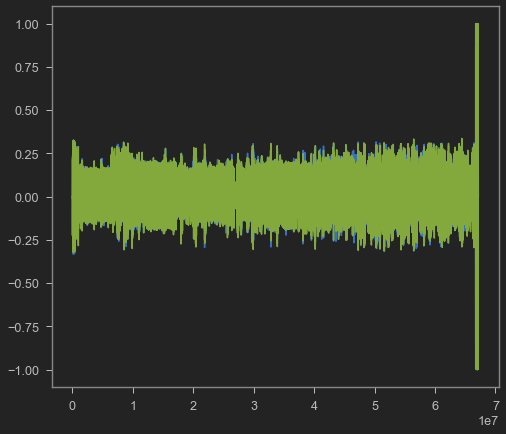

In [17]:
waveform, sample_rate = torchaudio.load(audio_li[0])
n_waveform, n_sample_rate = torchaudio.load(noise_li[0])

plt.figure()
plt.plot(waveform.t().numpy())

In [18]:
# find the lowest sample rate and we'll set them all to that
def find_lowest_sample_rate(audio_li=audio_li, noise_li=noise_li):
    min = np.inf
    for i in audio_li + noise_li:
        _, sample_rate = torchaudio.load(noise_li[0])
        if sample_rate < min: min = sample_rate
    return min

In [19]:
base_rate = find_lowest_sample_rate()
sample_rate = base_rate
base_rate

44100

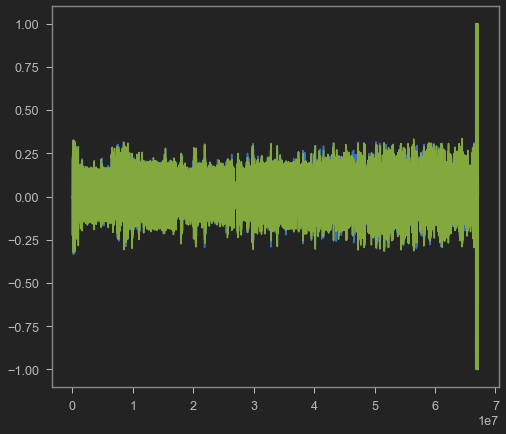

In [20]:
transformed = transforms.Resample(sample_rate, base_rate)(waveform)
plt.figure()
plt.plot(transformed.t().numpy())

In [21]:
# remove the first minute of audio from either end to remove intro
def cut_audio(tensor:torch.Tensor, seconds:int=60, sample_rate:int=base_rate) -> torch.Tensor: 
    cutoff = sample_rate * 60
    tensor = tensor[:, cutoff:-cutoff]
    return tensor

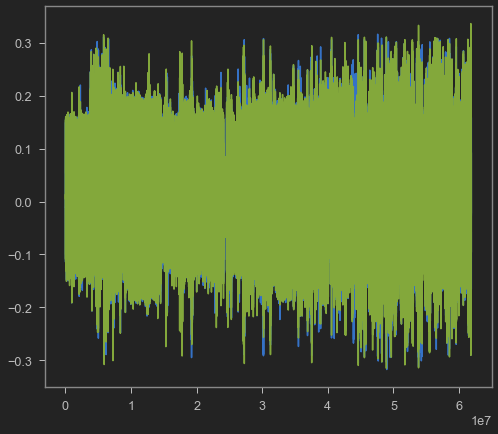

In [22]:
cut = cut_audio(transformed, seconds=120)
plt.figure()
plt.plot(cut.t().numpy())

In [23]:
def resample_audio(data_li, new_sample_rate:int) -> pd.DataFrame:
    waves = []
    for i, p in enumerate(data_li):
        waveform, sample_rate = torchaudio.load(p)
        waveform = transforms.Resample(sample_rate, new_sample_rate)(waveform)
        waveform = cut_audio(waveform, seconds=60, sample_rate=new_sample_rate)
        waves.append(waveform)
        print(f'Finished {i + 1} of {len(data_li)}')
    df = pd.DataFrame(data=waves, columns=['waveform'])
    return df

In [24]:
# audio_df = resample_audio(audio_li, base_rate)
# all files are already at the base sample_rate

In [25]:
# let's get a better way of doing this
if 'audio_df' in globals():
    del audio_df
torch.cuda.get_device_properties(0).total_memory

3221225472

In [26]:
class AudioLoader(DataLoader):
    def __init__(self, root_dir, sample_rate=44100, transform=None):
        self.root_dir = root_dir
        self.sample_rate = sample_rate
        self.transform = transform
        self.locations = self.locations_builder(root_dir)
    
    def locations_builder(self, root_dir):
        pass
        
    def __len__(self):
        pass

In [27]:
wave, sample_rate = torchaudio.load(audio_li[0])
wave.shape[1]

67160064

In [31]:
def get_random_noise(speech_file, noise_dir=noise_path, out_dir='./input/cleaned/', samples=1, seconds:int=10, 
                    cut_seconds:int=120):
    speech = AudioSegment.from_wav(audio_path + speech_file)
    # remove first and last minute from speech, then shave it into clean 30-second intervals
    step = seconds * 1000
    speech = speech[cut_seconds * 1000: -cut_seconds * 1000]
    speech = speech[:-(len(speech) % step)]
    
    pbar = tqdm(range(0, len(speech), step))
    for i in pbar:
        for j in range(samples):
            noise_file = noise_dir + random.choice(os.listdir(noise_dir))
            noise = AudioSegment.from_wav(noise_file)
            clip = speech[i:i + step]
            start = random.randint(0, len(noise) - step - 1)
            noise = noise[start:start + step]
            combined = clip.overlay(noise)
            combined.export(f'{out_dir}x/{speech_file}clip{i}version{j}.wav', format='wav')
            clip.export(f'{out_dir}y/{speech_file}clip{i}version{j}.wav', format='wav')
            pbar.update(1)
    return combined

In [32]:
for i, file in enumerate(os.listdir(audio_path)):
    print(f'file {i + 1} of {len(os.listdir(audio_path))}')
    mix_file = get_random_noise(file, noise_dir=noise_path, out_dir='./input/cleaned/', samples=1, seconds=10, 
                                cut_seconds=120)
mix_file

file 1 of 11


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:50<00:00,  2.54it/s]


file 2 of 11


100%|████████████████████████████████████████████████████████████████████████████████| 166/166 [01:05<00:00,  2.55it/s]


file 3 of 11


100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [02:07<00:00,  2.74it/s]


file 4 of 11


100%|████████████████████████████████████████████████████████████████████████████████| 282/282 [01:41<00:00,  2.77it/s]


file 5 of 11


100%|████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.71it/s]


file 6 of 11


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


file 7 of 11


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:52<00:00,  2.65it/s]


file 8 of 11


100%|████████████████████████████████████████████████████████████████████████████████| 335/335 [02:02<00:00,  2.73it/s]


file 9 of 11


100%|████████████████████████████████████████████████████████████████████████████████| 261/261 [01:39<00:00,  2.62it/s]


file 10 of 11


100%|████████████████████████████████████████████████████████████████████████████████| 409/409 [02:31<00:00,  2.69it/s]


file 11 of 11


100%|████████████████████████████████████████████████████████████████████████████████| 306/306 [01:56<00:00,  2.62it/s]


In [77]:
# we have successfully synthesized speech with random noise!

In [42]:
def example_file(path='./input/cleaned/x/'):
    samples = os.listdir(path)
    random_noise_file = random.choice(samples)
    return {'title': random_noise_file, 
            'file':AudioSegment.from_wav(path + random_noise_file)}

In [46]:
example = example_file()
title, file = example['title'], example['file']
print(title)
file

12 Comics You Need to See - Comedy Central Stand-Up Presents.mp3.wavclip540000version0.wav
